# A Cycle of Twelve

## 1. Solve by maximum likelihood

In [3]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import re
import sys
% matplotlib inline

UsageError: Line magic function `%` not found.


#### CODE FOR PARSING INPUT (CREDIT: MORIARTY'S CODE, moriarty.py)

In [4]:
df = pd.read_table("w08-data.tbl.txt", header=[0,1], delim_whitespace=True)[1:]
sigma_true = [int(c[1].split("+-")[-1]) for c in df.columns]
sigma_true

[20, 2, 20, 5, 5, 20, 2, 20]

In [5]:
times = [4,4,8,8,16,16,24,24]  ## I've spent too much time on other research projects lemme save time for this

In [6]:
df = df.T.astype(float)
df

anise   kiwi  carrot  grape  tangerine  melon  clementine  spinach  \
4hr  +-20  23.76  74.46   62.08  55.74       0.00  48.00       72.22    39.62   
     +-2   23.19  54.53   72.83  43.46      18.83  27.93       56.16    27.26   
8hr  +-20  33.33  59.97   31.45  55.83      28.75  53.07       49.29     0.00   
     +-5   29.36  24.63   49.08  65.21      39.69  57.49       72.70    33.72   
16hr +-5   58.09  34.45   12.61  40.75      65.80  60.84       30.23    59.37   
     +-20  53.23   0.00   18.49  57.33      45.29  57.65       42.15    70.99   
24hr +-2   32.63  62.12   76.04  18.13      17.48  17.38       32.11    47.72   
     +-20  23.48  25.04   91.07  29.24      61.24   3.83        0.00    29.73   

            beet  huckleberry  lentil  cauliflower  
4hr  +-20  61.48        36.77   53.58        49.54  
     +-2   43.18        31.89   68.50        65.97  
8hr  +-20  15.43         0.00   83.86        77.94  
     +-5   28.25        20.23   78.84        54.80  
16hr +-5   37.14        51.81   15.83         9.68  
     +-20  43.53        87.98    9.53        30.73  
24hr +-2   61.96        53.55   43.90        54.75  
     +-20  40.37        66.11    0.00        20.60

### Max LLH

In [43]:
def cal_y_hat(b, a, phi, timepoint):
     return b + a*np.sin(2*math.pi*(timepoint+phi)/24)

def circadian_nll(p, real_exps, sigmas, timepoints):
    """ calculated the negative log likelihood of the circadian oscillatior distribution"""
    b, a, phi = p[0], p[1], p[2]    
    residuals = [real_exp - cal_y_hat(b,a,phi, timepoint) for real_exp, timepoint in zip(real_exps, timepoints)]
    ll = sum([stats.norm.logpdf(res, 0, s) for res,s in zip(residuals, sigmas)])
             
    return -ll


# def circadian_nll(p, D, sigmas, timepoints):
#     # convert the values from p into the linear regression form
#     b = p[0]
#     a = p[1]
#     phi = p[2]
    
#     resids = []
    
#     # calculate each of the residuals
#     for i in range(len(T)):
#         # calculate the estimated y based on guess
#         y_hat = b + a * np.sin(2. * math.pi * (T[i] + phi) / 24)
        
#         # calculate the residual
#         e = D[i] - y_hat
#         resids.append(e)
    
#     # calculating likelihood (data independent)
#     ll = 0
#     for i in range(len(resids)):
#         ll += stats.norm.logpdf(resids[i], 0, S[i])
    
#     return -ll


In [44]:
iteration = 20
def correct_phi(phi):
    """we want it between 0 and 24"""
    return phi%24

def correct_amplitude(amp, phi):
    """does +- for oscillation (cycles)"""
    if amp < 0: 
        return -amp, correct_phi(phi+12)
    return amp, correct_phi(phi)

def max_llh(gene):
    nll_best = float('inf')
    for i in range(iteration):
        x0 = [np.random.uniform(0, 100), np.random.uniform(0, 100), np.random.uniform(0, 24)]  ## initial guesses
        new_guess = optimize.minimize(circadian_nll, x0, (list(df[gene]), sigma_true, times), bounds = [(0.0,None), (None,None), (None, None)])
        if new_guess.fun < nll_best:
            a, phi = correct_amplitude(new_guess.x[1], new_guess.x[2])
            b = new_guess.x[0]
    return [b,a,phi]
            

In [45]:
max_llh_d = {gene:max_llh(gene) for gene in list(df.columns)}
max_llh_d

{'anise': [40.172719640062155, 17.24441075837993, 13.715490009581059],
 'kiwi': [41.51504464795965, 21.208736757201017, 5.73987417122181],
 'carrot': [44.65460463209814, 34.6760090290521, 4.158165384628033],
 'grape': [41.95482038258766, 27.71537342787658, 20.15963516076843],
 'tangerine': [40.927140766500806, 26.241820238795455, 15.993743200267215],
 'melon': [44.800173487202116, 27.890739642286846, 17.599525360643927],
 'clementine': [44.28898550968995, 25.27009545851369, 21.972214692908974],
 'spinach': [45.43016076299112, 20.33460090378709, 11.747027232266557],
 'beet': [41.57799037055371, 21.381024395821907, 7.543745791662715],
 'huckleberry': [42.48525255822614, 22.244336296755456, 9.946427259237577],
 'lentil': [44.49016063122901, 30.892175999158578, 23.730133312286416],
 'cauliflower': [39.70333981057692, 27.01266761216833, 2.0991253617804517]}

In [51]:
max_llh_df = pd.DataFrame.from_dict(max_llh_d, columns=["b(tpm)","a(tpm)","phi(hr)"], orient="index")
max_llh_df

,b(tpm),a(tpm),phi(hr)
anise,40.172720,17.244411,13.715490
kiwi,41.515045,21.208737,5.739874
carrot,44.654605,34.676009,4.158165
grape,41.954820,27.715373,20.159635
tangerine,40.927141,26.241820,15.993743
melon,44.800173,27.890740,17.599525
clementine,44.288986,25.270095,21.972215
spinach,45.430161,20.334601,11.747027
beet,41.577990,21.381024,7.543746
huckleberry,42.485253,22.244336,9.946427


### Moriarty's methods, OLS
Downloase from pset material, still, obviously not my code 

In [52]:
#! /usr/bin/env python3

# Moriarty's linear least squares answer for "the cycle of twelve"
#
# Usage:
#   ./moriarty.py w08-data.tbl
#

import numpy as np
import math
import re
import sys

# Ooh look! Parsing for the w08-data.tbl
# This leaves us with
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t
#   
datafile = sys.argv[1]
with open("w08-data.tbl.txt") as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)

X = times
S_true = sigma_true

# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g], rcond=-1)[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # now in hours
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24



## Output
#
print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'b', 'a', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for g in range(G):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genenames[g], b_fit[g], a_fit[g], p_fit[g]))



    
# Output the data set to a file
# Useful for checking if the parser works; compare to original table.
#
def output_data(outfile):
    with open(outfile, 'w') as f:
        print("{0:12s} ".format(""), end='', file=f)
        for i in range(N):
            print("{0:4.0f}hr ".format(X[i]), end='',file=f)
        print('', file=f)

        print("{0:12s} ".format("gene"), end='', file=f)
        for i in range(N):
            label = "+-{0:.0f}".format(S_true[i])
            print("{0:>6s} ".format(label), end='',file=f)
        print('',file=f)

        print("{0:12s} ".format("------------"), end='',file=f)
        for i in range(N):
            print("{0:6s} ".format("------"), end='',file=f)
        print('',file=f)

        for g in range(G):
            print("{0:12s} ".format(genenames[g]), end='',file=f)
            for i in range(N):
                print("{0:6.1f} ".format(Y[g][i]), end='',file=f)
            print('',file=f)
 

genename          b      a      p
------------ ------ ------ ------
anise         38.76  16.61  14.44
kiwi          36.53  21.48   2.13
carrot        44.81  37.24   4.81
grape         46.05  21.31  19.76
tangerine     39.52  19.77  13.42
melon         44.01  28.86  18.22
clementine    41.89  27.75  21.39
spinach       43.27  22.72  11.75
beet          40.63  17.22   7.30
huckleberry   48.45  34.77  10.29
lentil        38.06  42.31  22.39
cauliflower   40.60  25.65  23.32


## 2. Compare solutions
Moriarty is incensed that you have a different solution. He offers to bet you on who's right. Compute the total log likelihood (summed over all 12 genes) for Moriarty's solution and yours. Which is more likely, and by how much?

In [53]:
moriarty_nll = 0
moriarty_nll = sum([circadian_nll([b_fit[i], a_fit[i], p_fit[i]], Y[i], S_true, X) for i in range(G)])
moriarty_nll

556.3133834158384

In [60]:
max_llh_nll = sum([circadian_nll(max_llh_d[gene], list(df[gene]), sigma_true, times) for gene in df.columns])
max_llh_nll

317.8920121930598

In [92]:
print ('Total log likelihood given max likelihood parameter estimates: {}'.format(my_total_nll))

Total log likelihood given max likelihood parameter estimates: 0


In [11]:
print ('Converting to ratio of likelihoods: {}'.format(np.exp(mor_total_nll - my_total_nll)))

Converting to ratio of likelihoods: 6.300661343937003e+62


Our ratio of likelihoods at the end is a really big number, which means that the probability of observing the data given our maximum likelihood regression model is much higher than the probability of observing the data given Moriarty's OLS model, by a factor of $6.3 \times 10^{62}.$

## 3. Plot the fits

In [61]:
# setting x-values and table of y-values
time_ints = np.arange(0, 24.1, 0.1)
mor_preds = np.zeros((G, len(time_ints)))
my_preds = np.zeros((G, len(time_ints)))

In [62]:
# making a method to calculate expression using the circadian oscillator function
def f(b, a, phi, t):
    return b + a * np.sin(2. * math.pi * (t + phi) / 24)

In [63]:
# populating mor_preds and my_preds with the predicted values based on the respective models
for i in range(G):
    for j in range(len(time_ints)):
        mor_preds[i][j] = f(b_fit_m[i], a_fit_m[i], p_fit_m[i], time_ints[j])
        my_preds[i][j] = f(b_fit[i], a_fit[i], p_fit[i], time_ints[j])

NameError: name 'b_fit_m' is not defined

In [64]:
# separating observed data points by low, med, and high reliability
# high, med, and low variance in residuals respectively
low = np.where(S_true == 20.)
med = np.where(S_true == 5.)
high = np.where(S_true == 2.)

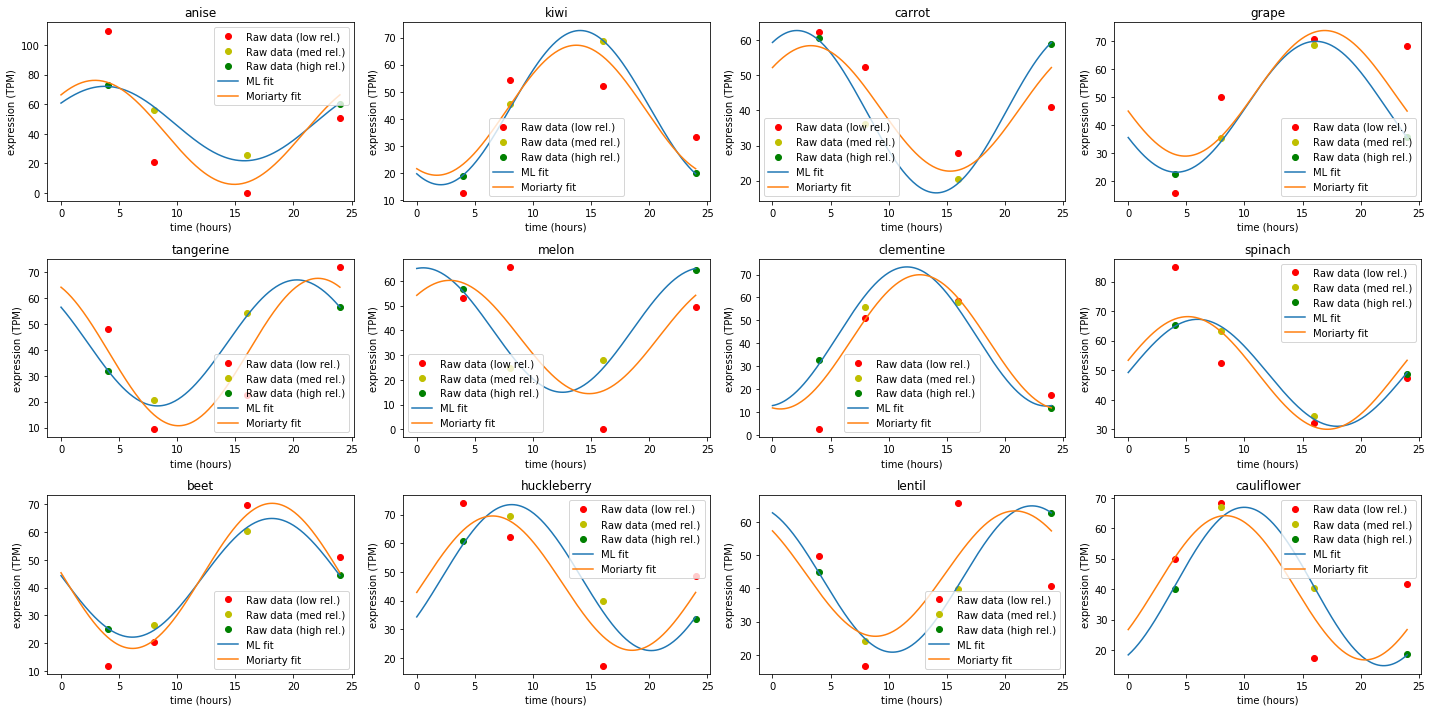

In [16]:
# plotting the 3x4 graphs
f = plt.figure(figsize=(20,10))
for i in range(G):
    ax = f.add_subplot(3,4,i+1)
    ax.plot(X[low], Y[i][low], 'ro')
    ax.plot(X[med], Y[i][med], 'yo')
    ax.plot(X[high], Y[i][high], 'go')
    plt.xlabel('time (hours)')
    plt.ylabel('expression (TPM)')
    plt.title(genenames[i])
    ax.plot(time_ints, my_preds[i], '-')
    ax.plot(time_ints, mor_preds[i], '-')
    ax.legend(['Raw data (low rel.)', 'Raw data (med rel.)', 'Raw data (high rel.)',
               'ML fit','Moriarty fit'])
    ax.plot()
plt.tight_layout()

### Observations

From the plots above, we can see that, for each gene, our model seems to fit the observed data from high and medium reliability experiments very well, as our model's curves seem to be able to touch or get close those points pretty accurately. In contrast, Moriarty's model curves seem to stray further away from the observed data with high and medium reliability than our model's. Furthermore, the curves in Moriarty's model seem to pull closer to the data points with low reliability.

The reason we see this discrepancy between the fit curves of the two models lies in the reliabilities of the experiments. In our model, we calculate negative log likelihoods based on the log PDFs of the residuals. However, for each experiment the residuals are distributed differently based on their reliabilites -- lower reliability corresponds to residuals with a Gaussian distribution with a higher variance than higher reliability. However, in Moriarty's model, he uses the ordinary least squares regression model, which makes the assumption that the residuals come from a Gaussian distribution with the same variance. This assumption is not correctly met, as we are given that the experiments have varying reliabilities. I hypothesize that because of this false assumption of equal variances (or homoscedasticity), this causes Moriarty's OLS model curves to be pulled closer to the data points from low reliability experiments, and thus have a lower likelihood of the data coming from Moriarty's model than ours.